<center>
<img src="https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/img/this_is_data_anal.png" width="200" height="200"><br>
</center>

# ch.05 데이터 종합 분석 예제

## 5.1 중고나라 휴대폰 거래가격 예측하기

이번 예제에서 사용하는 데이터는 https://www.data.go.kr/ 에서 제공하는 '네이버 중고나라' 데이터, 그리고 통신 3사 사이트에서 제공하는 휴대폰 공시가격 데이터를 기반으로 만들어진 것이다.

### step.1 탐색적 분석: 중고나라 데이터 분석하기

예제에서 사용할 중고나라 데이터셋은 다음과 같은 피처로 구성되어 있다.

- create_date : 판매(or 구매) 게시글이 올라온 시점
- price : 게시글 작성자가 제안한 휴대폰의 거래가격
- text : 게시글의 제목과 본문을 합친 텍스트 데이터
- phone_model : 휴대폰의 기종
- factory_price : 휴대폰의 공시가격
- maker : 휴대폰 제조사
- price_index : 판매 게시글이 올라온 시점에서의 휴대폰 물가 지수 데이터

- 중고나라 데이터셋 살펴보기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/home/jaeyoon89/python-data-analysis/data/used_mobile_phone.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


다음으로 개별 피처들을 탐색한다.

- 개별 피처 탐색하기 : date 피처 탐색

In [3]:
# create_date로 부터 '월'을 의미하는 month 정보를 피처로 추출한다.
df['month'] = df['create_date'].apply(lambda x : x[:7])

# 월별 거래 횟수를 계산하여 출력한다.
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

date 피처에서 월별 게시글의 개수를 살펴본 결과, 이 데이터는 2016년 10월과 2017년 3월에 집중적으로 수집된 데이터라는 것을 알 수 있다.
데이터의 개수를 일자별 시계열 그래프로도 나타내보자.

- 개별 피처 탐색하기: date 피처 탐색

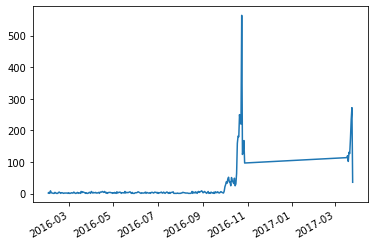

In [4]:
# 일별 거래 횟수를 계산하여 그래프로 출력한다.
df_day = pd.to_datetime(df['create_date'].apply(lambda x : x[:10])).value_counts()
df_day.plot()
plt.show()

그리고 아래와 같이 price 피처의 탐색을 통해 중고나라에서 거래되고 있는 중고 휴대폰의 가격이 어느 정도인지 살펴볼 수 있다. 그래프의 분포를 살펴보면, 대부분의 중고 휴대폰이 60만원 이하의 가격대를 형성하고 있고, 몇몇은 그 이상에도 거래되는 것을 볼 수 있다.

- 개별 피처 탐색하기 : price 피처 탐색


<AxesSubplot:>

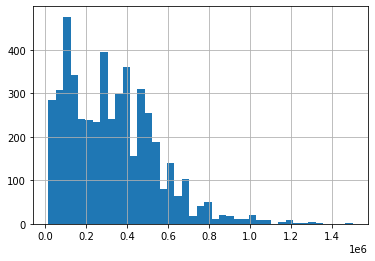

In [5]:
# 가격의 분포를 그래프로 탐색한다.
df['price'].hist(bins="auto")

이번엔 휴대폰의 동일 기종 내에서의 가격 분포를 살펴보자. 이를 위해 phone_model을 grouby하여 그룹별 평균값과 표준편차를 구한 뒤, 모든 price의 z-score를 계산하였다. 이 값은 '동일기종' 내에서의 상대적 가격을 나타낸 값이다.

- 개별 피처 탐색하기 : price 피처 탐색

<AxesSubplot:>

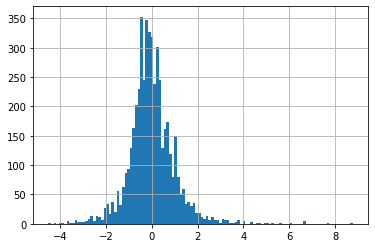

In [6]:
# 휴대폰 기종(phone_model)별 가격의 평균과 표준편차를 계산한다.
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의 z-score를 계산한다. 이는 해당 데이터의 가격이 기종별 평균에 비해 어느 정도로 높거나 낮은지를 
# 알 수 있게 하는 점수이다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

이 그래프로 출력한 결과, 동일 기종 내에서 price 피처의 분포는 정규분포에 가깝다는 것을 알 수 있다.
이번엔 factory_price 피처의 분포, 그리고 factory_price와 price 간의 관계를 탐색해 보자.

- 개별 피처 탐색하기 : factory_price 피처 탐색

<AxesSubplot:xlabel='factory_price', ylabel='price'>

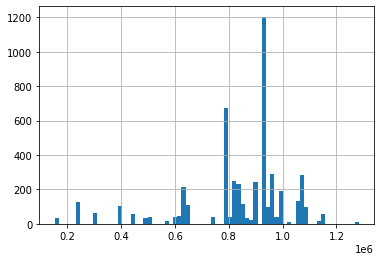

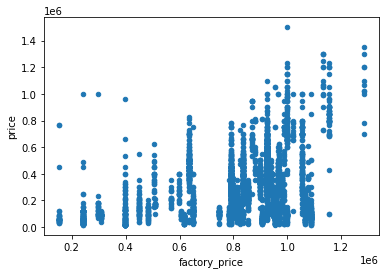

In [7]:
# factory_price 피처의 분포를 탐색한다.
df['factory_price'].hist(bins="auto")

# factory_price와 price 피처를 산점도 그래프로 출력하여 상관 관계를 살펴본다.
df.plot.scatter(x='factory_price', y='price')

위 그래프의 출력 결과, 두 피처는 양의 상관 관계를 가지고 있다. 이를 통해 factory_price는 중고 휴대폰 판매 가격에 꽤 중요한 영향을 미친다. 다음으로 phone_model 피처를 탐색한 결과, 휴대폰 기종의 개수는  총 64개로 나타났다. 상위 5개의 기종을 제외하면 대부분 10 ~ 90개 사이의 데이터를 가지고 있다는 것을 알 수 있다.

- 개별 피처 탐색하기 : phone_model 피처 탐색

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0e363db128>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e363db6d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0e363cd390>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0e363dbc88>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e363dbf60>],
 'means': []}

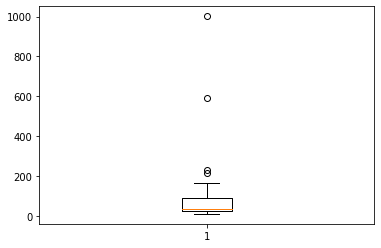

In [8]:
# 기종별 총 거래 데이터 개수를 집계한다.
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴보자.
plt.boxplot(model_counts)

지금까지 탐색한 피처를 바탕으로 가격 예측 모델을 학습해보자. 그 과정에서 도출되는 피처 중요도 분석을 통해 어떤 피처가 예측 모델에 중요한 피처인지를 알 수 있다. 이러한 분석은 렌덤포레스트라는 모델로 수행할 수 있다.

- 렌덤 포레스트 모델이란?

렌덤포레스트 모델은 앞서 살펴보았던 의사결정 나무 분석 방법을 응용한 것으로 의사 결정 나무를 여러 개 모아 하나의 숲을 구성하는 방법이다. 하나의 모델이 정답을 푸는 것이 아닌, 여러 개의 모델이 정답을 함께 푸는 것이기 때문에 더 정확한 학습이 가능하다.또한 이 방법은 모델이 생성되는 과정에서의 피처 중요도를 계산하기 때문에 탐색적 데이터 분석에 자주 사용된다. 랜덤 포레스트 모델은 회귀와 분류, 두 가지에 모두 적용이 가능하다.

렌덤 포레스트는 sklearn 라이브러리의 RandomForestRegressor 클래스로 사용 가능하다. 이 클래스의 fit 함수를 실행하여 모델을 학습한 뒤, feature_importances_를 출력하면 피처 중요도를 출력할 수 있다. 아래의 실행 결과는 모델의 예측 평가 점수인 R2 score, RMSE를 나타낸 것이다. Train score와 Test score의 차이가 심한 것을 미루어 볼 때, 이 예측 모델은 과적합이 일어났다고 할 수 있다.

- Random forest regressor를 이용한 가격 예측

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [10]:
# 데이터를 학습/테스트용 데이터로 분리한다.
df = df[['price','phone_model','factory_price','maker','price_index','month']]
df = pd.get_dummies(df,columns=['phone_model','maker','month'])
X = df.loc[:, df.columns !='price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [11]:
# 랜덤 포레스트 모델을 학습한다.
forest = RandomForestRegressor(n_estimators=1000,
                              criterion='mse')
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [12]:
# 학습한 모델을 평가한다.
print('MSE train: %.3f, test: %.3f' %(mean_squared_error(y_train,y_train_pred),
                                     mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f'%(r2_score(y_train, y_train_pred),
                                    r2_score(y_test, y_test_pred)))

MSE train: 10629606583.939, test: 13869786617.291
R^2 train: 0.781, test: 0.683


아래의 코드와 실행 결과는 랜덤 포레스트 모델의 피처 중요도를 출력한 것이다.

[('factory_price', 0.4059412771341484),
 ('maker_apple', 0.2969665704508786),
 ('phone_model_galaxy s3 3g 8gb', 0.02214335755126495),
 ('phone_model_iphone se 64gb', 0.02184903571534052),
 ('price_index', 0.02067440244383609),
 ('phone_model_galaxy s4 32gb', 0.017086545532462798),
 ('month_2017-03', 0.01478287257051149),
 ('maker_samsung', 0.014712789035793653),
 ('phone_model_galaxy s6 32gb', 0.012582924738080153),
 ('month_2016-05', 0.01099365095990527)]

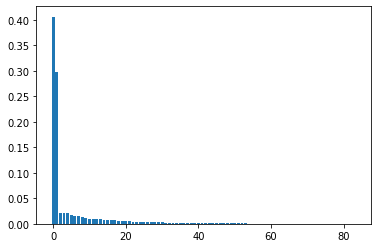

In [13]:
# 학습한 모델의 피처 중요도를 그래프로 살펴본다.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 학습한 모델의 피처 중요도를 출력한다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

그렇다면 시간은 모델에 어떤 영향을 미칠까? 이를 알아보기 위해 month 피처의 중요도만 살펴보자.

In [14]:
# month 피처 중, 영향력이 높은순으로 정렬하여 출력한다.
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.01478287257051149)
('month_2016-05', 0.01099365095990527)
('month_2016-09', 0.008403642222469207)
('month_2016-04', 0.00754796183598632)
('month_2016-10', 0.006461208993586404)
('month_2016-06', 0.004434834144756636)
('month_2016-08', 0.0036054588147535877)
('month_2016-07', 0.002716414447187438)
('month_2016-03', 0.0024471929326292602)
('month_2016-02', 0.0010583458515554083)


위 코드의 결과를 보면 '최근'에 가까운 'month'일수록 피처의 중요도가 높은 것을 알 수 있다.

### stpe.2 피처 엔지니어링: 예측 모델 계산하기

지금까지 수행한 탐색적 데이터 분석의 내용은 아래의 표와 같다. 이 내용을 토대로 가격 예측모델의 성능을 개선하기 위한 피처 엔지니어링을 적용해보자.

- 기존 피처 가공하기 : 'create_date'

In [15]:
# 데이터를 다시 불러오자.
df = pd.read_csv('/home/jaeyoon89/python-data-analysis/data/used_mobile_phone.csv')

In [16]:
from datetime import datetime
import time

In [17]:
# create_date 피처를 수치적으로 계산하기 위해 unixtime으로 변환하는 함수를 정의한다.
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

In [18]:
# create_date 피처를 '현재와 얼마나 가까운 데이터인지' 판단하기 위한 점수를 생성한다. 먼저 unixtime으로 데이터를 변환한다.
df['create_unixtime'] = df['create_date'].apply(lambda x : date_to_unixtime(x[:10]))

In [19]:
# 변환된 unixtime에 min-max 스케일링을 적용한다.
df['create_time_score'] = (df['create_unixtime']- df['create_unixtime'].min()) / (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date','create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489849e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477408e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477321e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490195e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460300e+09,0.165468


다음은 phone_model에 대한 피처 엔지니어링을 수행한다. phone_model 피처는 '제품명+용량'으로 구성되어 있어 이를 나누어주기만 하면 2개의 분리된 피처를 얻을 수 있다. 어떤 효과가 있는지 살펴보자.

- 기존 피처의 가공 : phone_model

In [20]:
# phone_model 피처에서 저장 용량(phone_model_storage) 피처를 추출한다.
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

# phone_model 피처에서 기존 세부명(phone_model_detail) 피처를 추출한다.
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


아래 코드는 phone_model 피처를 분리함으로써 얻을 수 있는 효과를 알아보기 위해 피처 분리이전과 이후의 분포를 상자 그림으로 비교해 보자.

- 기존 피처의 가공 : phone_model

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0e310b57f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e310b5da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0e310b5588>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0e310c3390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e310c3668>,
 'means': []}

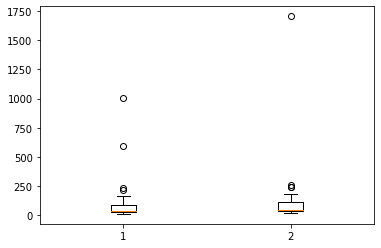

In [21]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계한다.
model_counts = df['phone_model'].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계한다.
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처간의 기종별 거래 데이터 개수를 비교하자.
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

이를 살펴본 결과, 쏠림 현상이 심해진 하나의 기종을 제외하면 전체적인 분포가 안정적으로 변한 것을 알 수 있다.

다음으론 텍스트 정보에 대한 피처 엔지니어링을 수행하자. 텍스트 정보에는 물품의 상태가 나타나 있을 것이다. 이는 가격 예측에 영향을 미칠 것이기 때문이다. 따라서 물품의 상태를 분류할 수 있는 감성 분류가 필요하다. 

- 감성 분류로 물품의 상태 분류하기

-1.3966616903783375
1.666982156397844


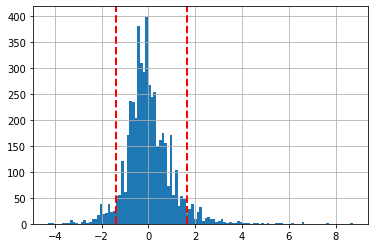

In [22]:
# 거래 가격(price)의 z-score를 계산한다. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수이다.
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

# 거래 가격의 z-score(price_by_group)의 분포를 그래프로 출력한다.
ax = df['price_by_group'].hist(bins="auto")

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound 라고 지정한다.
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가한다.
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

# lower_bound를, upper_bound 출력한다.
print(lower_bound)
print(upper_bound)

감성 분류의 정답 데이터를 'price_level'이라는 피처로 생성한 결과는 다음과 같다. 

- 감성 분류로 물품의 상태 분류하기.

In [23]:
# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류하는 함수를 정의한다.
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"

# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류합니다.
df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], 
                                                         row['price_upper']), axis=1)
df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


다음으로 텍스트 전처리 과정을 진행하자. 우선 used_mobile_phone_stopword.pkl 파일을 불러오자.

- 텍스트 전처리하기

In [24]:
import pickle
import re

# 중고나라 불용어 사전을 불러오자.
with open('/home/jaeyoon89/python-data-analysis/data/used_mobile_phone_stopwords.pkl','rb') as f:
    stopwords = pickle.load(f)
# 불용어 사전에 등록된 단어 10개를 출력하자.
print(stopwords[:10])

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']


In [25]:
df['price_level'].value_counts()

1    4296
0     334
2     321
Name: price_level, dtype: int64

아래의 코드는 전처리된 데이터의 형태소를 추출하는 과정이다. 코드에서 정의된 함수 text_cleaning()은 다음과 같은 전처리를 수행한다.


- 1. 텍스트에서 특수문자를 제거한다. 단'+'와 ',' 문자는 제거하지 않는다.
- 2. 텍스트에서 숫자를 제거한다.

또한 get_pos()는 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수이다.

- 형태소 단위로 추출하기

In [26]:
from konlpy.tag import Okt

# + 를 제외한 특수문자를 제거하고, 숫자형태의 문자를 제거한다.
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [27]:
# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수이다.
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

In [28]:
# 위 함수들을 적용한 형태소 추출을 테스트한다.
df['text'] = df['text'].apply(lambda x : text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


다음은 추출한 형태소에서 가장 빈도수가 높은 형태소 2500개를 선정한다. 2500개로 단어를 제한하는 이유는 텍스트 데이터의 피처를 제한하기 위함이다. 이를 제한하지 않으면 텍스트 데이터의 피처는 몇 만개, 혹은 몇 백만개로 늘어날 수 있다.

- 빈출 형태소 2500개 선정하기

In [29]:
from collections import Counter

# get_pos() 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출한다.
corpus = sum(df['text'].apply(lambda x : get_pos(x)).tolist(), [])

# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출한다.
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

이제 전처리가 완료된 텍스트 데이터를 학습 데이터셋의 형태로 변환한다. 피처를 변환하는 방식은 TF-IDF를 사용하였으며, 아래 코드에서 클래스 불균형을 맞추기 위해 부정데이터:중립데이터:긍정데이터를 1:3:1의 비율로 데이터를 추출하였다. 일반적으론 1:1:1의 비율로 데이터를 추출하지만 예제에선 부정 데이터와 긍정 데이터의 양이 많지 않기 때문에 중립 데이터의 비중을 늘렸다.

- TF-IDF 벡터 생성하기

In [46]:
df['price_level'].value_counts()

1    4296
0     334
2     321
Name: price_level, dtype: int64

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 빈출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의한다.
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 1:3:1 비율로 랜덤 샘플링을 수행한다.
negative_random = df[df['price_level']=='0'].sample(321, random_state=30)
neutral_random = df[df['price_level']=='1'].sample(321*3, random_state=30)
positive_random = df[df['price_level']=='2'].sample(321, random_state=30)

# 샘플링 완료된 데이터셋을 정의한다.
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF를 수행하여 피처를 변환한다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류를 위한 학습 데이터셋을 정의한다.
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
print(x_train.shape)
print(x_test.shape)

(1284, 2476)
(321, 2476)


실행 결과 학습 데이터셋은 1284개, 테스트 데이터셋은 321개가 생성되었고 형태소를 표현하는 피처는 2476개가 생성되었다.

아래 코드는 TF-IDF 피처 변환이 완료된 데이터셋으로 분류 모델을 학습한 것이다. 분류 모델은 SVM이라는 모델을 사용했고, 약 0.8정도의 학습되었다. 이에 대한 Confusion Matrix를 살펴보면 꽤나 정확하게 분류 모델이 학습되었음을 알 수 있다.

- 상품의 상태 분류하기

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 비선형 SVM 분류 모델을 학습하고 평가한다.
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))

Accuracy: 0.77


In [49]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력한다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
print(confmat)

[[ 30  28   4]
 [ 10 181  10]
 [  2  21  35]]


### Step.3 예측 : 중고 휴대폰 거래가 예측하기

이제 다시 한번 가격 예측 모델을 학습해 보자. 아래의 실행 결과는 새로운 피처로 예측 모델을 다시 학습한 결과이다. 이를 통해 Train R2 score, Test R2 score 등의 지표가 매우 상승하였음을 확인할 수 있지만, 여전히 과적합이 발생하고 있다는 것 또한 확인할 수 있다. 그리고 피처 중요도를 다시 분석한 결과, 영향력이 높은 피처 중 create_time_score, product_status가 있다는 것을 확인할 수 있다.

- Random forest regressor 재학습하기

In [50]:
# text 피처로부터 '상품 상태 피처'를 생성한다.
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

In [52]:
# 랜덤 포레스트 모델 학습을 위한 데이터를 준비한다.
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage',
                'phone_model_detail', 'product_status']]
df = pd.get_dummies(df, columns=['maker','phone_model_storage','phone_model_detail','product_status'])

In [53]:
# 학습/테스트 데이터를 분리한다.
X = df.loc[:, df.columns !='price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [54]:
# 랜덤 포레스트 모델을 학습하고 평가한다.
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 4773645749.137, test: 11017774616.937
R^2 train: 0.902, test: 0.748


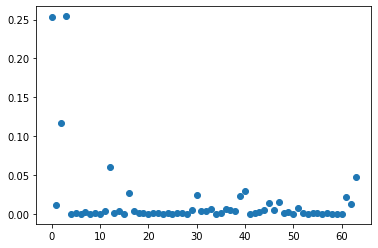

In [56]:
# 피처 중요도 plot 을 출력한다.
importances = forest.feature_importances_
plt.plot(importances, "o")

In [57]:
# 피처 중요도를 print로 출력한다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

[('maker_apple', 0.2543507464906023),
 ('factory_price', 0.25333310231260026),
 ('create_time_score', 0.11654417957554435),
 ('phone_model_storage_16gb', 0.06025384434282711),
 ('product_status_2', 0.047092572747126506),
 ('phone_model_detail_galaxy s7 edge', 0.029231983949269756),
 ('phone_model_storage_64gb', 0.026883102768965418),
 ('phone_model_detail_galaxy note5', 0.0247083709924326),
 ('phone_model_detail_galaxy s7', 0.022464167900807866),
 ('product_status_0', 0.021591495211777917)]

예측이 얼마나 잘 된 것인지를 산점도 그래프로도 살펴보자. 그래프의 x,y축은 각각 실제 가격, 예측 가격을 의미한다. 아래 그래프를 통해 몇몇 이상치를 제외하면 예측이 잘 수행된 것을 확인할 수 있다.

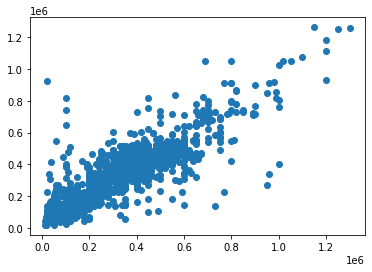

In [58]:
plt.scatter(y_test.values, y_test_pred)

모델을 학습할 때는 파라미터를 어떻게 설정하느냐에 따라 예측의 성능이 달라질 수 있다. 반복적인 실행으로 최적의 파라미터를 찾아내는 방법 중의 하나가 Greedy Randomized Search라는 방법이다. 그리고 다음의 코드는 이 방법을 실행하는 코드이다. 우리는 파라미터의 후보군을 설정하고, RandomizedSearchCV 클래스가 실행할 random_grid를 지정해주기만 하면 된다.

- 최적의 모델 파라미터 찾기

In [60]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정한다.
n_estimators = [int(x) for x in np.linspace(start=200, stop = 2000, num = 10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의한다.
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'bootstrap': bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1)

# RandomizedSearchCV 모델을 학습한다.
X = df.loc[:, df.columns !='price']
y = df['price']
optimal_forest.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

그리고 다음의 출력 결과는 Greedy Randomzed Search를 실행하여 찾아낸 최적의 파라미터이다. 이 파라미터로 모델을 학습할 때, 가장 좋은 성능을 낼 수 있다.

In [61]:
# 앞서 선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합을 출력한다.
print(optimal_forest.best_params_)

{'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}


- 최적 모델 학습 결과

최적의 파라미터를 적용한 모델로 중고 휴대폰의 가격을 예측하고 평가한다.

MSE train: 8808363320.130, test: 7645657594.144
R^2 train: 0.818, test: 0.825


<BarContainer object of 64 artists>

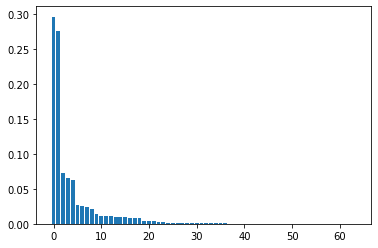

In [64]:
# 최적의 파라미터를 적용한 모델로 중고 휴대폰의 가격을 예측하고 평가한다.
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 가격 예측 모델의 피처 중요도 plot을 출력한다.
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

In [66]:
# 가격 예측 모델의 피처 중요도를 출력한다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

[('factory_price', 0.29661887725382863),
 ('maker_apple', 0.2756146378767071),
 ('phone_model_storage_16gb', 0.07214587829278914),
 ('create_time_score', 0.06581894080008098),
 ('product_status_2', 0.06258234575279699),
 ('phone_model_detail_galaxy s7 edge', 0.02707710135203515),
 ('phone_model_detail_iphone 6', 0.025031998840692824),
 ('product_status_0', 0.024499299222839332),
 ('phone_model_detail_galaxy s4', 0.02053025327910071),
 ('product_status_1', 0.01380911645897503)]

- 예측 결과 산점도 그래프

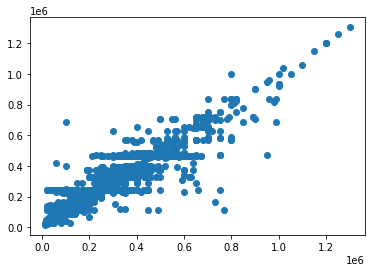

In [67]:
# 테스트 데이터의 y값과, 예측된 y값을 산점도 그래프를 활용하여 상관 관계를 살펴본다.
plt.scatter(y_test.values, y_test_pred)

출처 : 이것이 데이터 분석이다 with 